<a href="https://colab.research.google.com/github/sowmen/face_recognition_demo/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install face_recognition
!pip install dlib

     |████████████████████████████████| 100.2MB 71kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=305109afe646ee9158a7aac204298f0662763c1b620ba221bcf41b0938be8d5b
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
import os
from tqdm import tqdm
import pickle
from glob import glob

## Create embeddings from image database

In [12]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [33]:
DIR = 'mark-hamill' # Set the directory containing images to use as base

In [38]:
images = []
face_locations = []
face_embeddings = []
for f in tqdm(os.listdir(DIR)):
    im = cv2.imread(os.path.join(DIR, f))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = image_resize(im, 512)

    locations = face_recognition.face_locations(im)
    if len(locations) > 0:
        face_location = locations[0]
        face_embedding = face_recognition.face_encodings(im)[0]
        
        images.append(im)
        face_locations.append(face_location)
        face_embeddings.append(face_embedding)

if len(face_locations) == 0:
    print("\nNo faces were detected in any of the images. Try different set of images")
else:
    print(f"\nDetected {len(face_locations)} faces.")


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Detected 5 faces.


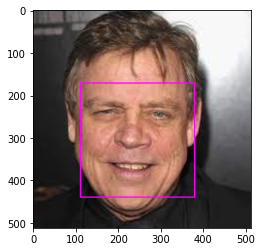

In [40]:
# Visualize a random sample from the directory
id = np.random.randint(0, len(images))
sample = images[id]
cv2.rectangle(sample, (face_locations[id][3], face_locations[id][0]), (face_locations[id][1], face_locations[id][2]), (255,0,255), 2)
plt.imshow(sample)
plt.show()

In [41]:
def save_embeddings(embeddings, path, overwrite=True):
    if os.path.exists(path) and overwrite == False:
        print(f"File {path} exists. To overwrite set 'overwrite=True'")
        return
    
    with open(path, "wb") as f:
        pickle.dump(embeddings, f)

# Save the precomputed face embeddings. This can be loaded later to recognize new images
save_embeddings(face_embeddings, os.path.join(DIR,DIR+".pkl"), overwrite=False)

File mark-hamill/mark-hamill.pkl exists. To overwrite set 'overwrite=True'


['mark-hamill/mark-hamill_embedding.pkl',
 'sowmen/sowmen_embedding.pkl',
 'zuckerberg/zuckerberg_embedding.pkl']

In [56]:
# Testing a different image to check for similarity
test_image = cv2.imread('/content/IMG_20210615_162858.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = image_resize(test_image, 512)
test_image_embedding = face_recognition.face_encodings(test_image)[0]

database_paths = glob('*/**/*embedding*.pkl', recursive=True)
print(f"\nFound {len(database_paths)} saved embeddings")

databse_embeddings = []
for p in tqdm(database_paths, desc="Loading embeddings from databse"):
    with open(p, "rb") as f:
        databse_embeddings.append(pickle.load(f))

found = 0
for embedding in databse_embeddings:
    results = face_recognition.compare_faces(embedding, test_image_embedding)
    distances = face_recognition.face_distance(embedding, test_image_embedding)
    if True in results:
        print(f"Found match in database with minimum distance {round(min(distances), 4)}")
        found = 1
        break
if not found:
    print("No match found")


Loading embeddings from databse: 100%|██████████| 3/3 [00:00<00:00, 1043.97it/s]


Found 3 saved embeddings
Found match in database with minimum distance 0.2142
